# What does a Win look like?

Here I am going to see if we can determine how strongly certain factors influence the result of a football match and whether we can use them to predict the result.

## Dataset exploration

In [13]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import sys
sys.path.insert(0, r'..\src')
import utilities

# access the source dataset
df = utilities.get_master("fulldata")

# create a more descriptive index field
df["col_to_index"] = df["Team"] + " vs " + df["TeamOpp"] + " (" + df["Date"] + ")"
df.set_index('col_to_index', inplace=True) #, verify_integrity=True)

# longlist of relevant features
features_list = ['Win', 'Attendance', 'Goals', 'GoalsOpp', 'Shots', 'ShotsOpp', 'ShotsOnTarget', 'ShotsOnTargetOpp', 'ShotsHitWoodwork', 'ShotsHitWoodworkOpp', 'Corners', 'CornersOpp', 'Fouls', 'FoulsOpp', 'Offsides', 'OffsidesOpp', 'YellowCards', 'YellowCardsOpp', 'RedCards', 'RedCardsOpp', 'BookingPoints', 'BookingPointsOpp', 'Saves', 'SavesOpp', 'CleanSheet', 'CleanSheetOpp']
df = df[features_list]

# remove patchy data (and missing indexes)
df.dropna(inplace=True)
df = df[df.index.notnull()]

# create a random sample
df = df.sample(n=2000, random_state=1)

df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 2000 entries, Bury vs Oldham (2001-03-31) to Stoke vs Bury (2001-09-22)
Data columns (total 26 columns):
Win                    2000 non-null int64
Attendance             2000 non-null float64
Goals                  2000 non-null float64
GoalsOpp               2000 non-null float64
Shots                  2000 non-null float64
ShotsOpp               2000 non-null float64
ShotsOnTarget          2000 non-null float64
ShotsOnTargetOpp       2000 non-null float64
ShotsHitWoodwork       2000 non-null float64
ShotsHitWoodworkOpp    2000 non-null float64
Corners                2000 non-null float64
CornersOpp             2000 non-null float64
Fouls                  2000 non-null float64
FoulsOpp               2000 non-null float64
Offsides               2000 non-null float64
OffsidesOpp            2000 non-null float64
YellowCards            2000 non-null float64
YellowCardsOpp         2000 non-null float64
RedCards               2000 non-null float

,Win,Attendance,Goals,GoalsOpp,Shots,ShotsOpp,ShotsOnTarget,ShotsOnTargetOpp,ShotsHitWoodwork,ShotsHitWoodworkOpp,...,YellowCards,YellowCardsOpp,RedCards,RedCardsOpp,BookingPoints,BookingPointsOpp,Saves,SavesOpp,CleanSheet,CleanSheetOpp
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,...,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.00000,2000.000000,2000.000000
mean,0.393500,13882.993500,1.390500,1.342000,10.850500,10.680500,5.161000,5.041500,0.309000,0.322500,...,1.521000,1.535500,0.097500,0.109500,17.647500,18.092500,3.699500,3.77050,0.271500,0.291000
std,0.488648,14817.963777,1.241282,1.246119,4.686377,4.480453,2.758964,2.627781,0.593039,0.584521,...,1.258313,1.250409,0.317875,0.332513,16.003321,16.291306,2.299966,2.37353,0.444845,0.454337
min,0.000000,150.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.00000,0.000000,0.000000
25%,0.000000,3622.500000,0.000000,0.000000,8.000000,7.000000,3.000000,3.000000,0.000000,0.000000,...,1.000000,1.000000,0.000000,0.000000,10.000000,10.000000,2.000000,2.00000,0.000000,0.000000
50%,0.000000,7134.000000,1.000000,1.000000,10.000000,10.000000,5.000000,5.000000,0.000000,0.000000,...,1.000000,1.000000,0.000000,0.000000,10.000000,20.000000,3.000000,3.00000,0.000000,0.000000
75%,1.000000,20347.500000,2.000000,2.000000,14.000000,14.000000,7.000000,7.000000,1.000000,1.000000,...,2.000000,2.000000,0.000000,0.000000,30.000000,30.000000,5.000000,5.00000,1.000000,1.000000
max,1.000000,68600.000000,7.000000,6.000000,30.000000,41.000000,19.000000,16.000000,4.000000,4.000000,...,8.000000,6.000000,2.000000,3.000000,100.000000,115.000000,16.000000,17.00000,1.000000,1.000000


In [14]:
# look at matches with most outlier features
IQR = df.quantile(q=0.75) - df.quantile(q=0.25)
first_quartile = df.quantile(q=0.25)
third_quartile = df.quantile(q=0.75)
outliers = df[(df>(third_quartile + 1.5*IQR) ) | (df<(first_quartile - 1.5*IQR) )].count(axis=1)
outliers.sort_values(axis=0, ascending=False, inplace=True)
outliers.head(12)

col_to_index
Leeds vs Arsenal (2001-08-21)                  6
Hamburg vs Hansa Rostock (2001-04-29)          5
Stenhousemuir vs Partick (2000-08-19)          5
Rangers vs Celtic (2000-08-27)                 5
Ipswich vs Derby (2001-08-21)                  5
Hansa Rostock vs Ein Frankfurt (2001-02-04)    5
Leverkusen vs Dortmund (2001-03-17)            5
Ein Frankfurt vs Hansa Rostock (2001-02-04)    5
Bury vs Bristol Rvs (2000-10-06)               4
Dundee United vs Dundee (2001-11-03)           4
Bury vs Oldham (2001-03-31)                    4
Wolfsburg vs Kaiserslautern (2001-09-29)       4
dtype: int64

In [11]:
df.loc["Leeds vs Arsenal (2001-08-21)", :]

Win                      1.0
Goals                    2.0
GoalsOpp                 1.0
Shots                    5.0
ShotsOpp                14.0
ShotsOnTarget            2.0
ShotsOnTargetOpp         5.0
ShotsHitWoodwork         0.0
ShotsHitWoodworkOpp      0.0
Corners                  2.0
CornersOpp              10.0
Fouls                   29.0
FoulsOpp                28.0
Offsides                 2.0
OffsidesOpp              2.0
YellowCards              5.0
YellowCardsOpp           4.0
RedCards                 2.0
RedCardsOpp              0.0
BookingPoints          100.0
BookingPointsOpp        40.0
Saves                    4.0
SavesOpp                 0.0
CleanSheet               0.0
CleanSheetOpp            0.0
Name: Leeds vs Arsenal (2001-08-21), dtype: float64

In [15]:
df.loc["Hamburg vs Hansa Rostock (2001-04-29)", :]

Win                        1.0
Attendance             50000.0
Goals                      2.0
GoalsOpp                   1.0
Shots                     21.0
ShotsOpp                   9.0
ShotsOnTarget              9.0
ShotsOnTargetOpp           2.0
ShotsHitWoodwork           1.0
ShotsHitWoodworkOpp        0.0
Corners                    5.0
CornersOpp                 5.0
Fouls                     22.0
FoulsOpp                  23.0
Offsides                   4.0
OffsidesOpp                2.0
YellowCards                4.0
YellowCardsOpp             4.0
RedCards                   0.0
RedCardsOpp                1.0
BookingPoints             40.0
BookingPointsOpp          65.0
Saves                      1.0
SavesOpp                   7.0
CleanSheet                 0.0
CleanSheetOpp              0.0
Name: Hamburg vs Hansa Rostock (2001-04-29), dtype: float64

In [16]:
# Find the number of Wins and non Wins now in the data
df['Win'].value_counts()

0    1213
1     787
Name: Win, dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000000067EE71D0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x0000000068E385F8>]], dtype=object)

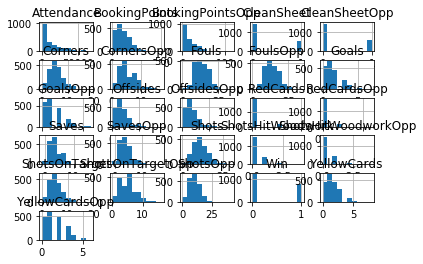

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt
df.hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000000044E4A400>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000000005D47D898>]], dtype=object)

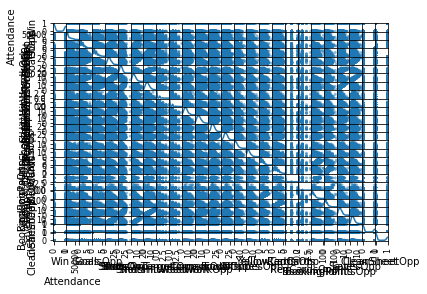

In [20]:
from pandas.tools.plotting import scatter_matrix
scatter_matrix(df, diagonal="kde")

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000000069B11C88>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000000006A775A58>]], dtype=object)

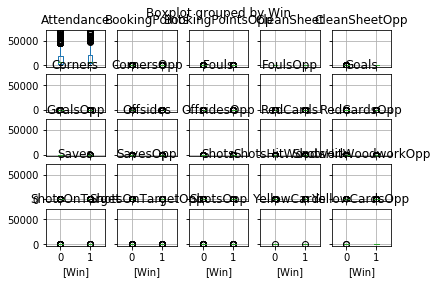

In [23]:
df.boxplot(by="Win")